<a href="https://colab.research.google.com/github/eduardogranillo/FisicaComputacional/blob/master/Actividad6/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
# Importamos las bibliotecas a utilizar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas.util.testing as tm

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados de la Notebook en la Jupyter
%matplotlib inline


In [184]:
# concentración de las operaciones del dataframe original df_dist

# Tomar la dirección URL del archivo en raw
url = 'https://raw.githubusercontent.com/eduardogranillo/FisicaComputacional/master/Actividad1/ClimatologiaDiaria.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.month

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

# Conversión de la columna de Mes a cadena de caracteres (en este caso Variable
# categórica), en lugar de tener los meses denotados por enteros.
# Función .dt.strftime('%b'), %b representa los meses en formato: Jan, Feb,...

# Eliminaremos la columna de Mes (numérico) y crearemos una nueva de Mes (caracteres)
df_meteo.drop('Mes', axis=1, inplace=True)
df_meteo['Mes'] = df_meteo['Fecha'].dt.strftime('%b')
df_meteo.info()
print(df_meteo.head())
print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
print(df_meteo_ts.head())
print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años  
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1956) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2020)]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   16063 non-null  datetime64[ns]
 1   Precip  16058 non-null  float64       
 2   Evap    10094 non-null  float64       
 3   Tmax    15199 non-null  float64       
 4   Tmin    15191 non-null  float64       
 5   Año     16063 non-null  int64         
 6   Mes     16063 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 878.6+ KB
       Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
0 1956-01-01     0.0   NaN   NaN   NaN  1956  Jan
1 1956-01-02     0.0   NaN   NaN   NaN  1956  Jan
2 1956-01-03     0.0   NaN   NaN   NaN  1956  Jan
3 1956-01-04     0.0   NaN   NaN   NaN  1956  Jan
4 1956-01-05     0.0   NaN   NaN   NaN  1956  Jan
           Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
16058 2010-06-26     0.0  10.8  33.0  14.5  2010  Jun
16059

In [185]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [186]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2010 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2000-01', '2009-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2000-01-01,1.8,NaN,22.5,-6.5,2000,Jan
2000-01-02,0.0,NaN,15.5,-6.0,2000,Jan
2000-01-03,0.0,NaN,18.5,-10.0,2000,Jan
2000-01-04,0.0,NaN,22.5,-9.5,2000,Jan
2000-01-05,0.0,NaN,20.0,-9.5,2000,Jan


In [187]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2000-01-01    22.5
2000-01-02    15.5
2000-01-03    18.5
2000-01-04    22.5
2000-01-05    20.0
Name: Tmax, dtype: float64

In [188]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()

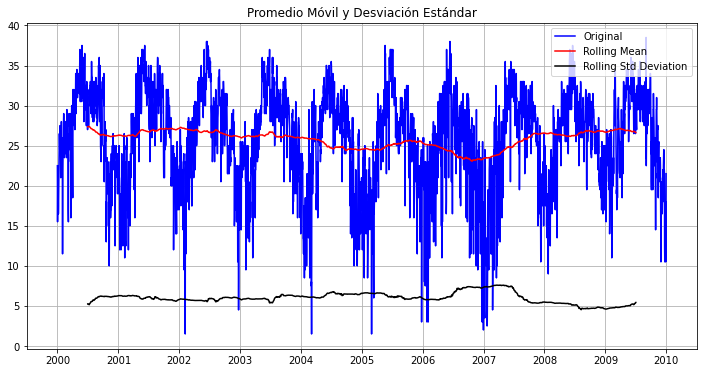

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.414252
p-value                           0.000280
#Lags Used                       18.000000
Number of Observations Used    3634.000000
Critical Value (1%)              -3.432151
Critical Value (5%)              -2.862336
Critical Value (10%)             -2.567194
dtype: float64


In [189]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

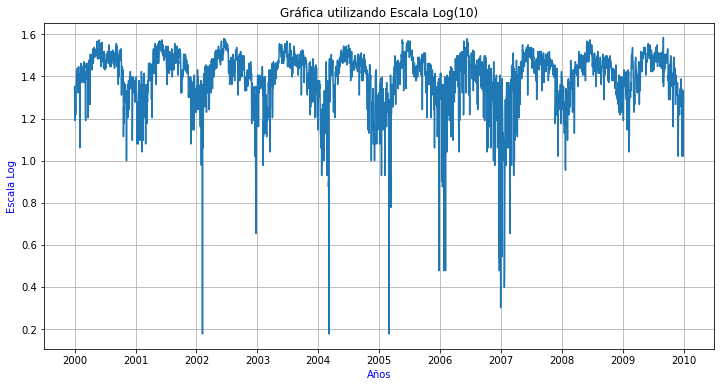

In [190]:
# En mi caso el valor de p ya es menor a 5%, pero de todos haré este paso.

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

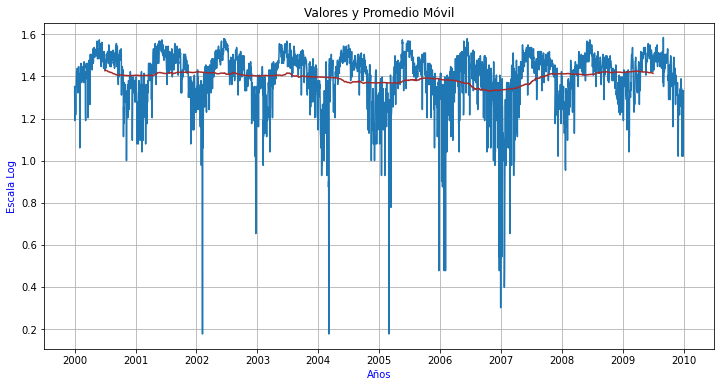

In [191]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();


In [192]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2000-01-01   NaN
2000-01-02   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
Name: Tmax, dtype: float64

In [193]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2000-07-01    0.019417
2000-07-02    0.034684
2000-07-03    0.019001
2000-07-04    0.048871
2000-07-05    0.026796
Name: Tmax, dtype: float64

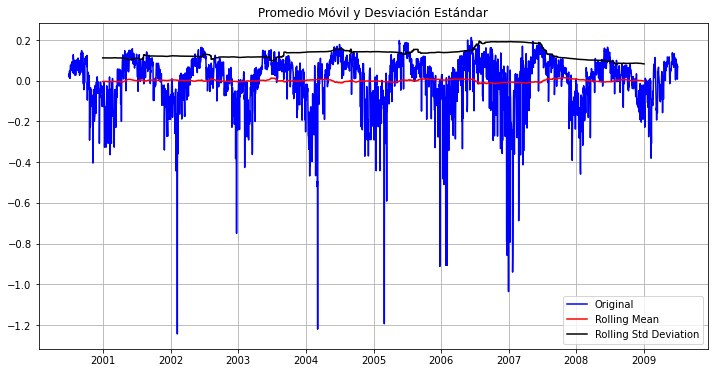

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -5.676316e+00
p-value                        8.688462e-07
#Lags Used                     1.400000e+01
Number of Observations Used    3.274000e+03
Critical Value (1%)           -3.432349e+00
Critical Value (5%)           -2.862423e+00
Critical Value (10%)          -2.567240e+00
dtype: float64


In [194]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

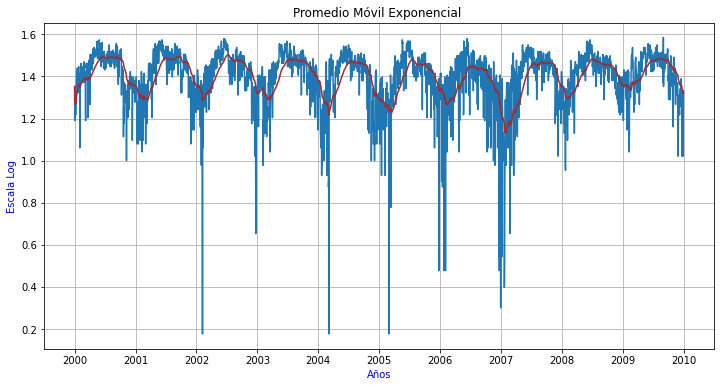

In [195]:
# En mi caso el valor para p disminuyó mucho.
# Sin embargo, sigo haciendo el siguiente paso.

# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [196]:
EWM_avg.head()


Fecha
2000-01-01    1.352183
2000-01-02    1.270322
2000-01-03    1.269248
2000-01-04    1.290705
2000-01-05    1.292867
Name: Tmax, dtype: float64

In [197]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

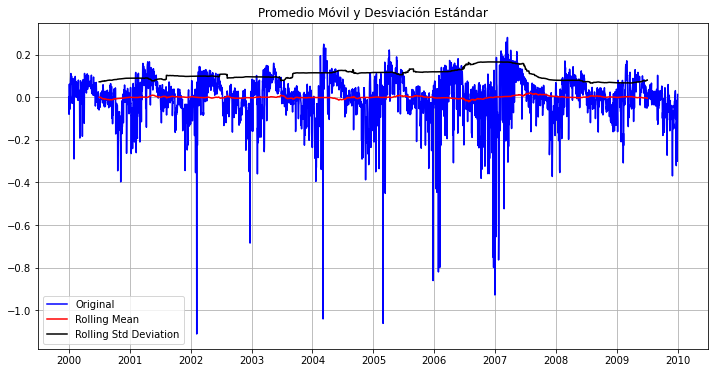

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.046680e+00
p-value                        1.306809e-07
#Lags Used                     2.700000e+01
Number of Observations Used    3.625000e+03
Critical Value (1%)           -3.432155e+00
Critical Value (5%)           -2.862338e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


In [198]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

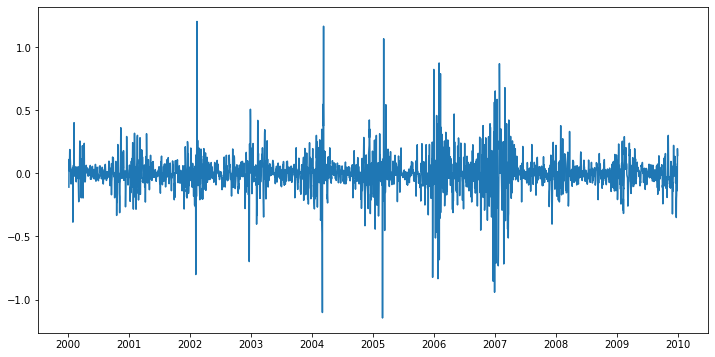

In [199]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

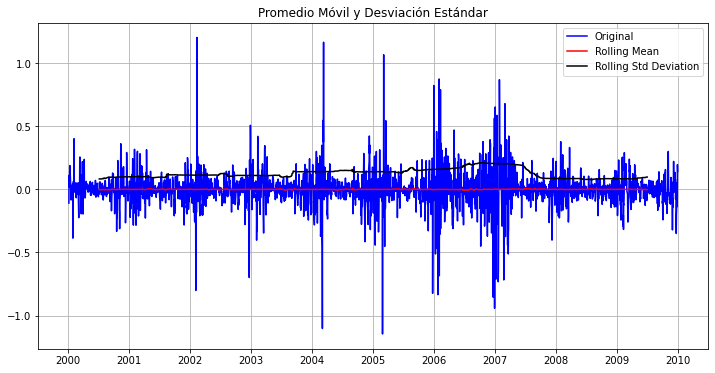

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.208164e+01
p-value                        2.225250e-22
#Lags Used                     3.000000e+01
Number of Observations Used    3.615000e+03
Critical Value (1%)           -3.432160e+00
Critical Value (5%)           -2.862340e+00
Critical Value (10%)          -2.567196e+00
dtype: float64


In [200]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [201]:
# Número de datos utilizados
len(ts_test_log_diff)

3646

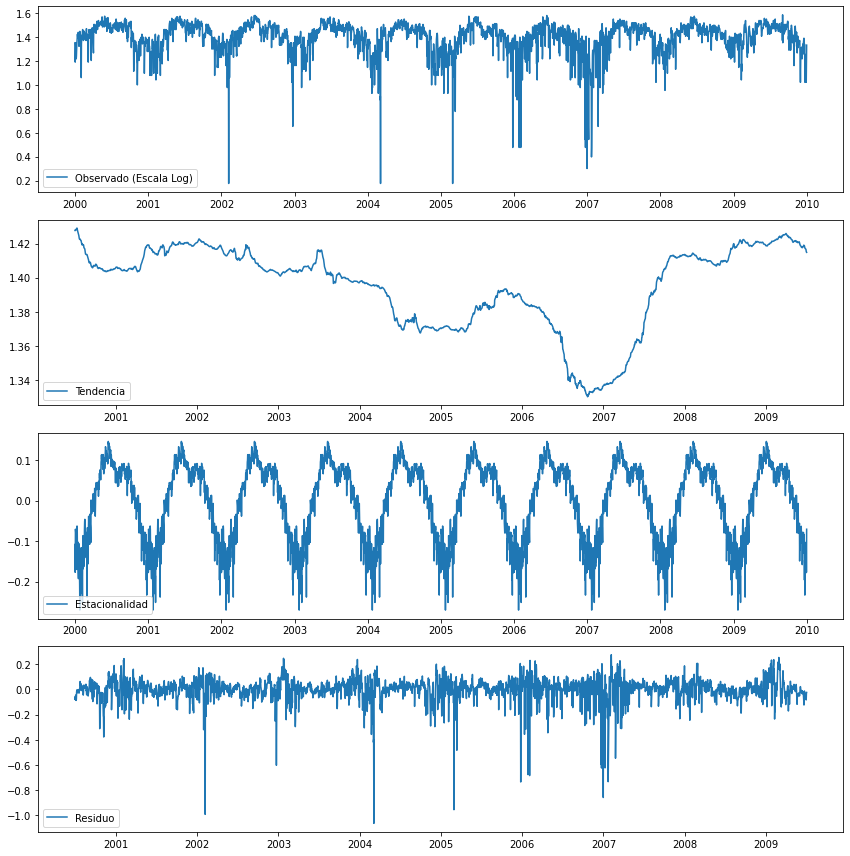

In [202]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

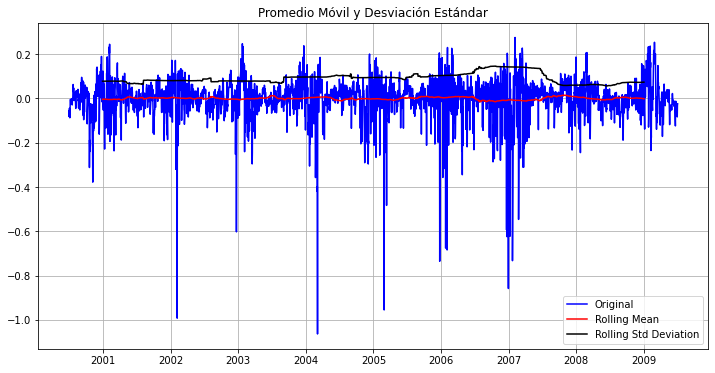

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.206687e+01
p-value                        2.397412e-22
#Lags Used                     1.400000e+01
Number of Observations Used    3.274000e+03
Critical Value (1%)           -3.432349e+00
Critical Value (5%)           -2.862423e+00
Critical Value (10%)          -2.567240e+00
dtype: float64


In [203]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

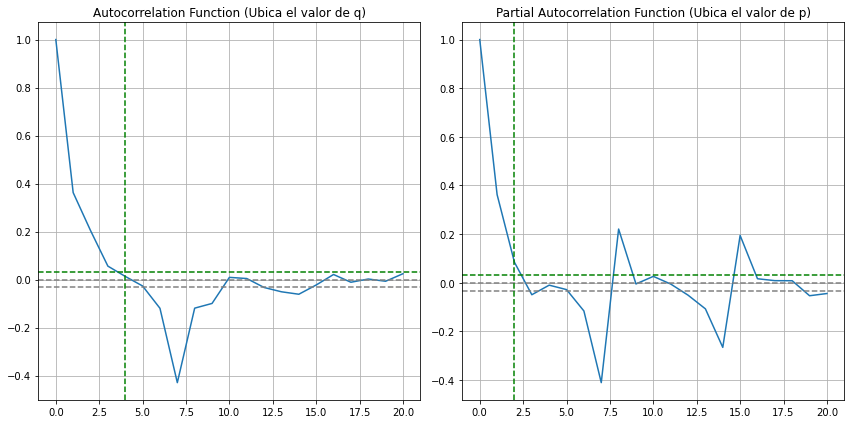

In [204]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3652
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3519.121
Method:                       css-mle   S.D. of innovations              0.092
Date:                Tue, 23 Feb 2021   AIC                          -7030.241
Time:                        07:58:03   BIC                          -7005.429
Sample:                    01-02-2000   HQIC                         -7021.405
                         - 12-31-2009                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.381e-06      0.001     -0.010      0.992      -0.002       0.002
ar.L1.D.Tmax    -0.4055      0.016    -24.923      0.000      -0.437      -0.374
ar.L2.D.Tmax    -0.1860      0.016    -11.42

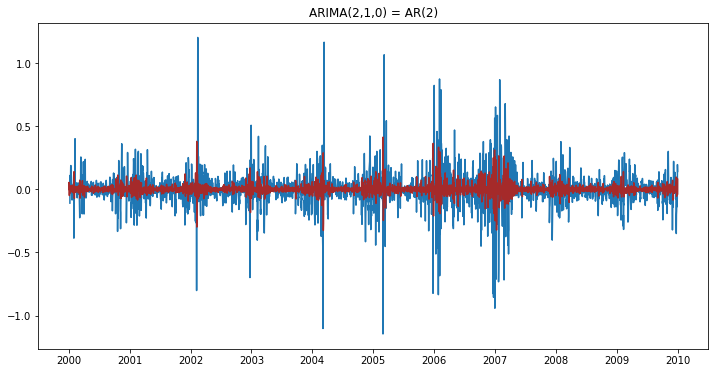

In [205]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3652
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3774.353
Method:                       css-mle   S.D. of innovations              0.086
Date:                Tue, 23 Feb 2021   AIC                          -7532.706
Time:                        07:58:10   BIC                          -7483.082
Sample:                    01-02-2000   HQIC                         -7515.034
                         - 12-31-2009                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.213e-05      0.000     -0.099      0.921      -0.000       0.000
ar.L1.D.Tmax    -0.3151      0.298     -1.056      0.291      -0.900       0.269
ar.L2.D.Tmax    -0.0855      0.125     -0.68

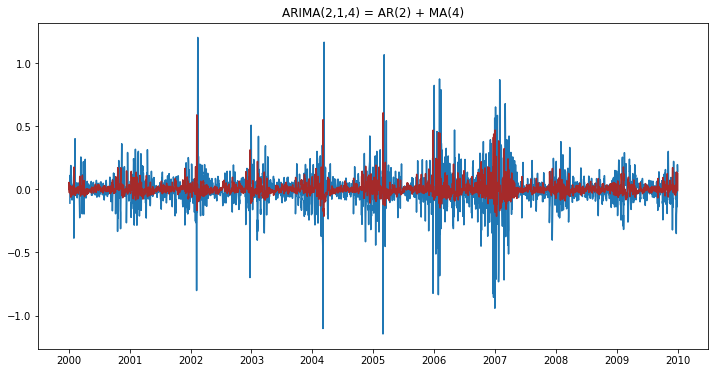

In [206]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


In [207]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2000-01-02   -0.000022
2000-01-03    0.055177
2000-01-04   -0.001202
2000-01-05   -0.026348
2000-01-06    0.006367
                ...   
2009-12-27    0.020778
2009-12-28    0.021414
2009-12-29   -0.004915
2009-12-30    0.129346
2009-12-31   -0.009411
Length: 3652, dtype: float64


In [208]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head(30))
print(predictions_ARIMA_log.tail(30))

Fecha
2000-01-01         NaN
2000-01-02    1.190310
2000-01-03    1.322349
2000-01-04    1.350981
2000-01-05    1.274682
2000-01-06    1.249405
2000-01-07    1.239048
2000-01-08    1.275464
2000-01-09    1.320637
2000-01-10    1.329970
2000-01-11    1.338409
2000-01-12    1.361046
2000-01-13    1.362918
2000-01-14    1.344723
2000-01-15    1.342544
2000-01-16    1.389404
2000-01-17    1.390775
2000-01-18    1.374155
2000-01-19    1.386981
2000-01-20    1.354181
2000-01-21    1.311572
2000-01-22    1.378720
2000-01-23    1.366549
2000-01-24    1.402720
2000-01-25    1.430393
2000-01-26    1.337024
2000-01-27    1.352441
2000-01-28    1.361697
2000-01-29    1.372279
2000-01-30    1.414251
dtype: float64
Fecha
2009-12-02    1.382078
2009-12-03    1.235513
2009-12-04    1.352549
2009-12-05    1.205430
2009-12-06    1.274447
2009-12-07    1.260209
2009-12-08    1.233708
2009-12-09    1.298432
2009-12-10    1.319213
2009-12-11    1.282490
2009-12-12    1.312775
2009-12-13    1.308193
2009-12

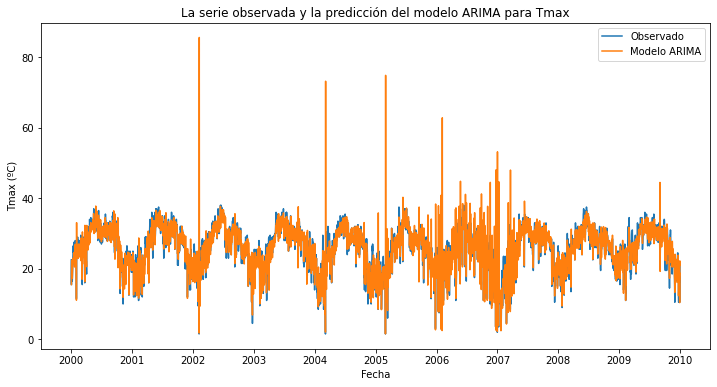

In [209]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

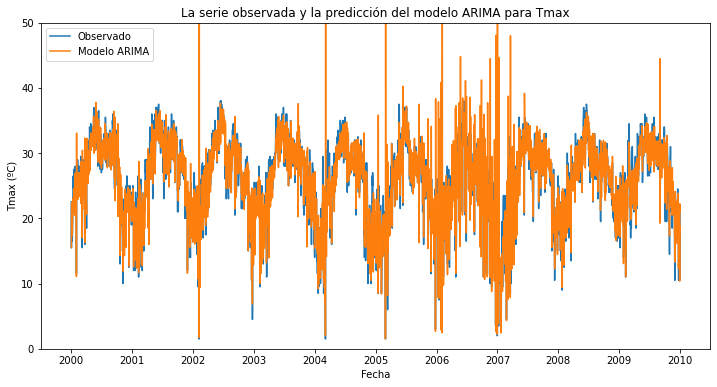

In [210]:
#Debido a que hay unos picos muy feos voy a delimitar el ylim
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.ylim(0,50)
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [211]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 3.108520590887865


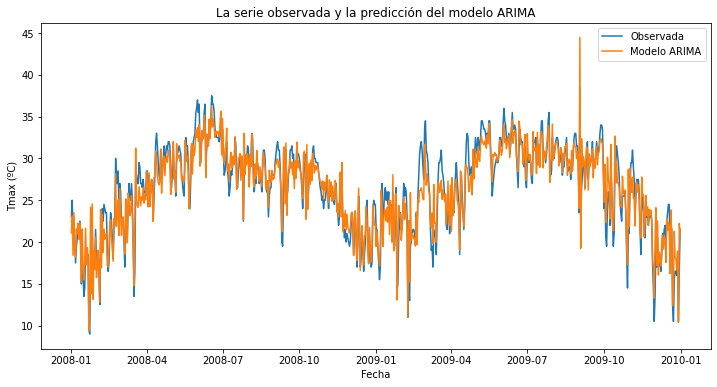

In [212]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

# Ahora para Tmin

In [213]:
# Vemos su encabezado
ts_90['Tmin'].head()

Fecha
2000-01-01    -6.5
2000-01-02    -6.0
2000-01-03   -10.0
2000-01-04    -9.5
2000-01-05    -9.5
Name: Tmin, dtype: float64

In [214]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico

ts_test2 = ts_90['Tmin'].copy()

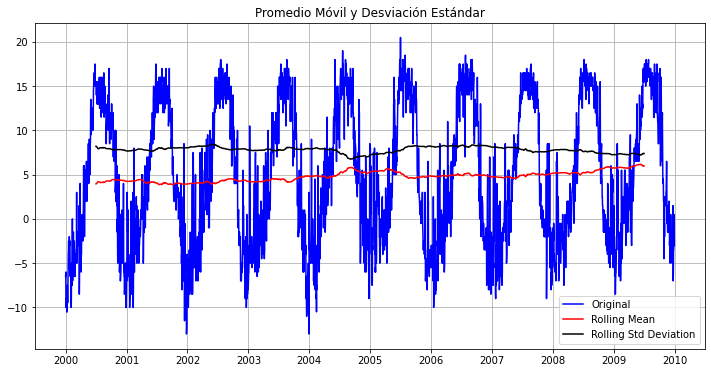

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.816765
p-value                           0.002740
#Lags Used                       28.000000
Number of Observations Used    3624.000000
Critical Value (1%)              -3.432156
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64


In [215]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test2)

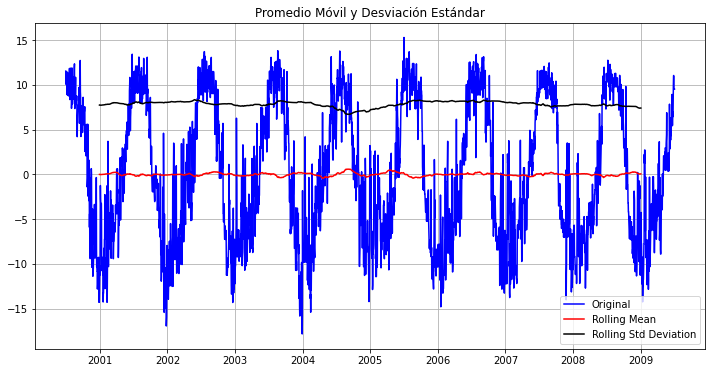

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.652322
p-value                           0.004836
#Lags Used                       28.000000
Number of Observations Used    3260.000000
Critical Value (1%)              -3.432358
Critical Value (5%)              -2.862427
Critical Value (10%)             -2.567242
dtype: float64


In [216]:
moving_avg2 = ts_test2.rolling(365, center=True).mean()
ts_test2_moving_ave_diff = ts_test2 - moving_avg2 
ts_test2_moving_ave_diff.dropna(inplace=True)
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test2_moving_ave_diff)

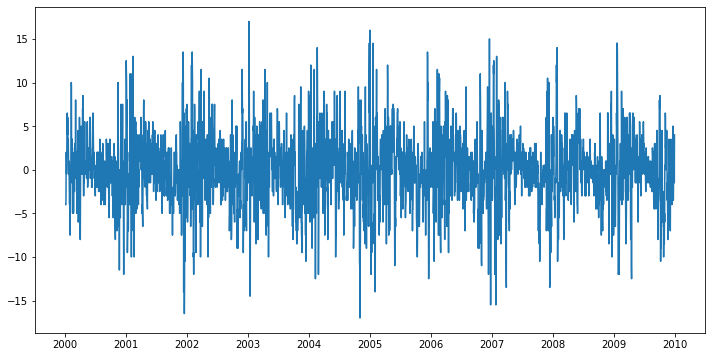

In [217]:
# Hacemos la diferenciación
ts_test2_diff = ts_test2 - ts_test2.shift(periods=7)
plt.plot(ts_test2_diff);

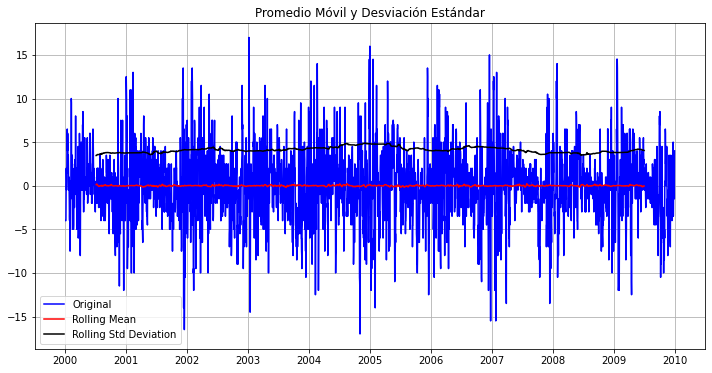

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.944236e+00
p-value                        9.079335e-15
#Lags Used                     3.000000e+01
Number of Observations Used    3.615000e+03
Critical Value (1%)           -3.432160e+00
Critical Value (5%)           -2.862340e+00
Critical Value (10%)          -2.567196e+00
dtype: float64


In [218]:
# Probamos la estacionaridad
ts_test2_diff.dropna(inplace=True)
test_stationarity(ts_test2_diff)

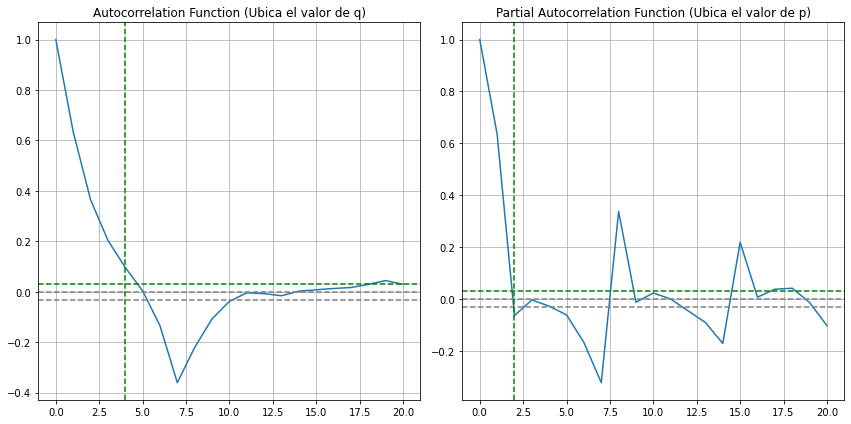

In [219]:
# Aplicamos ARIMA

lag_acf = acf(ts_test2_diff, nlags=20)
lag_pacf = pacf(ts_test2_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 3652
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8386.273
Method:                       css-mle   S.D. of innovations              2.405
Date:                Tue, 23 Feb 2021   AIC                          16780.546
Time:                        07:58:14   BIC                          16805.358
Sample:                    01-02-2000   HQIC                         16789.382
                         - 12-31-2009                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.030      0.044      0.965      -0.057       0.059
ar.L1.D.Tmin    -0.1515      0.016     -9.333      0.000      -0.183      -0.120
ar.L2.D.Tmin    -0.1933      0.016    -11.90

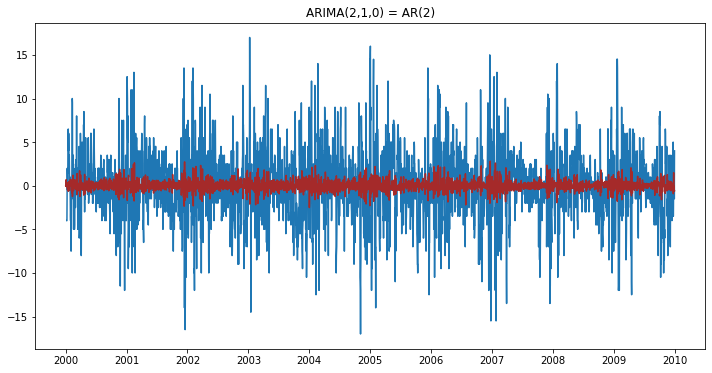

In [220]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test2, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test2_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 3652
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3774.353
Method:                       css-mle   S.D. of innovations              0.086
Date:                Tue, 23 Feb 2021   AIC                          -7532.706
Time:                        07:58:16   BIC                          -7483.082
Sample:                    01-02-2000   HQIC                         -7515.034
                         - 12-31-2009                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.213e-05      0.000     -0.099      0.921      -0.000       0.000
ar.L1.D.Tmax    -0.3151      0.298     -1.056      0.291      -0.900       0.269
ar.L2.D.Tmax    -0.0855      0.125     -0.68

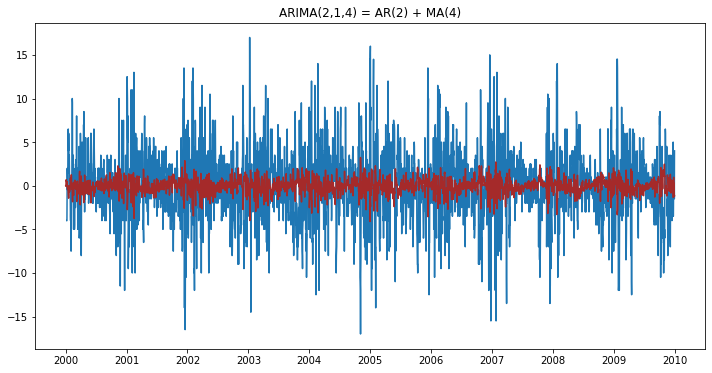

In [221]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test2, order=(2,1,4), missing='drop')
results2_ARIMA = model.fit(displ=-1)
plt.plot(ts_test2_diff)
plt.plot(results2_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


In [239]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions2_ARIMA_diff = pd.Series(results2_ARIMA.fittedvalues, copy=True)
print(predictions2_ARIMA_diff)

Fecha
2000-01-02    0.001482
2000-01-03   -0.061846
2000-01-04    0.511659
2000-01-05    0.688192
2000-01-06    0.517766
                ...   
2009-12-27    0.069792
2009-12-28    0.279189
2009-12-29   -0.149430
2009-12-30   -1.242645
2009-12-31   -1.166049
Length: 3652, dtype: float64


In [240]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions2_ARIMA = pd.Series(ts_test2, index = ts_test.index)
predictions2_ARIMA = predictions2_ARIMA.add(predictions2_ARIMA_diff)
print(predictions2_ARIMA.head())
print(predictions2_ARIMA.tail())

Fecha
2000-01-01          NaN
2000-01-02    -5.998518
2000-01-03   -10.061846
2000-01-04    -8.988341
2000-01-05    -8.811808
dtype: float64
Fecha
2009-12-27   -3.430208
2009-12-28   -2.720811
2009-12-29    0.350570
2009-12-30   -1.242645
2009-12-31   -4.166049
dtype: float64


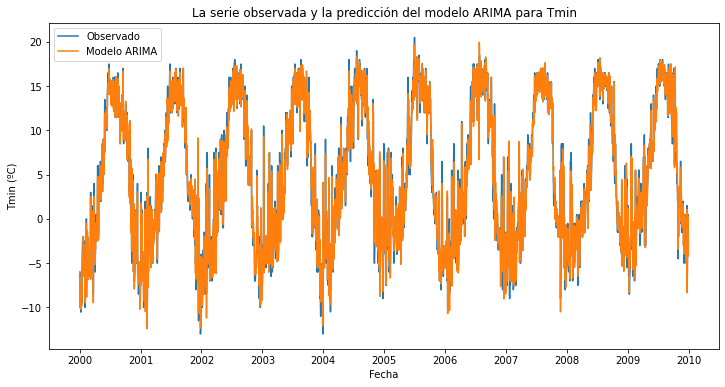

In [243]:
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [245]:

# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE2 = np.sqrt(np.mean((predictions2_ARIMA - ts_test2)**2))
print('RMSE:', RMSE)

RMSE: 3.108520590887865


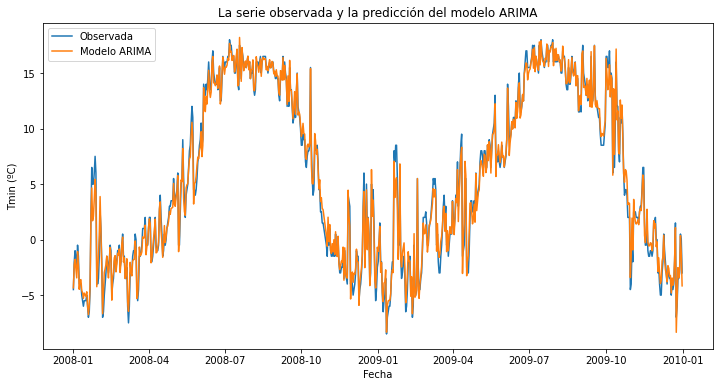

In [246]:
# Graficamos sólo los útimos datos de las series 
ts_test2_last = ts_test2.tail(730)
predictions2_ARIMA_last = predictions2_ARIMA.tail(730)
plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions2_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');